In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.datasets import cifar10
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
import os

# Cargar datos

In [ ]:
os.system('wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz')
os.system('tar xvzf gender.tgz')

# Load
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [ ]:
# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


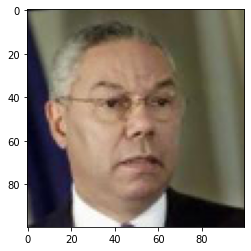

In [ ]:
## View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()

In [ ]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [ ]:
num_classes = 2

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

# Parámetros

In [ ]:
batch_size = 100
epochs = 75

In [ ]:
## Data Augmentation with an ImageGenerator
datagen = ImageDataGenerator(
    width_shift_range=0.1, # trasladar en la horizontal 20%
    height_shift_range=0.1, # trasladar en la vertical 20%
    horizontal_flip=True, # modo espejo
    zoom_range = 0.2, #Añadimos zoom
    rotation_range = 3, # rotación en grados
    shear_range = 0.1, # cambiar la perspectiva, modificar ángulo, "estirar" la imagen
    #brightness_range=0.2 # cambio de brillo 
    )

In [ ]:
# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.001)

# Model > 97%

In [ ]:
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

In [ ]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,128)
model=CBGN(model,256)
model=CBGN(model,512)

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_43 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 gaussian_noise_43 (Gaussian  (None, 100, 100, 32)     0         
 Noise)                                                          
                                                                 
 activation_53 (Activation)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                     

In [ ]:
## OPTIM AND COMPILE
opt = SGD(learning_rate=0.1, decay=1e-6)
adam = Adam(learning_rate=0.1)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
## TRAINING with DA and LRA
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[reduce_lr],
                            verbose=1)

Epoch 1/75
105/105 [==============================] - 27s 250ms/step - loss: 0.7813 - accuracy: 0.7648 - val_loss: 0.5310 - val_accuracy: 0.7749 - lr: 0.1000
Epoch 2/75
105/105 [==============================] - 25s 238ms/step - loss: 0.4573 - accuracy: 0.7816 - val_loss: 0.5544 - val_accuracy: 0.7749 - lr: 0.1000
Epoch 3/75
105/105 [==============================] - 25s 240ms/step - loss: 0.4391 - accuracy: 0.7832 - val_loss: 0.4823 - val_accuracy: 0.7749 - lr: 0.1000
Epoch 4/75
105/105 [==============================] - 25s 238ms/step - loss: 0.3867 - accuracy: 0.8192 - val_loss: 0.4872 - val_accuracy: 0.7957 - lr: 0.1000
Epoch 5/75
105/105 [==============================] - 26s 243ms/step - loss: 0.3629 - accuracy: 0.8321 - val_loss: 0.4344 - val_accuracy: 0.8331 - lr: 0.1000
Epoch 6/75
105/105 [==============================] - 25s 238ms/step - loss: 0.3463 - accuracy: 0.8484 - val_loss: 0.3122 - val_accuracy: 0.8754 - lr: 0.1000
Epoch 7/75
105/105 [==============================] 

In [ ]:
## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

83/83 [==============================] - 1s 9ms/step - loss: 0.0896 - accuracy: 0.9792
Test loss: 0.089569091796875
Test accuracy: 0.9792296290397644


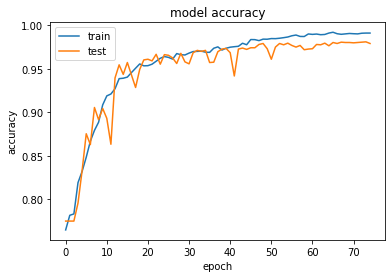

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# > 92% con menos de 100k params

In [ ]:
from keras.layers.convolutional import Conv2DTranspose
## DEF A BLOCK CONV + BN + GN
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  #model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

def CBGNT(model,filters,ishape=0):
    if (ishape!=0):
      model.add(Conv2DTranspose(filters, (3, 3), padding='same',
                  input_shape=ishape))
    else:
      model.add(Conv2DTranspose(filters, (3, 3), padding='same'))
    
    model.add(BN())
    model.add(GN(0.3))
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    return model

In [ ]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,10,x_train.shape[1:])
model=CBGN(model,20)
model=CBGN(model,40)
model=CBGN(model,80)

model=CBGNT(model,40)
model=CBGNT(model,20)
model=CBGNT(model,10)
model=CBGNT(model,3)

model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 10)      280       
                                                                 
 batch_normalization_16 (Bat  (None, 100, 100, 10)     40        
 chNormalization)                                                
                                                                 
 gaussian_noise_16 (Gaussian  (None, 100, 100, 10)     0         
 Noise)                                                          
                                                                 
 activation_18 (Activation)  (None, 100, 100, 10)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 20)      1820      
                                                                 
 batch_normalization_17 (Bat  (None, 100, 100, 20)    

In [ ]:
## OPTIM AND COMPILE
opt = SGD(learning_rate=0.1, decay=1e-6)
adam = Adam(learning_rate=0.1)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
## TRAINING with DA and LRA
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[reduce_lr],
                            verbose=1)

Epoch 1/75
105/105 [==============================] - 68s 628ms/step - loss: 0.6862 - accuracy: 0.7660 - val_loss: 0.5371 - val_accuracy: 0.7749 - lr: 0.1000
Epoch 2/75
105/105 [==============================] - 66s 622ms/step - loss: 0.4586 - accuracy: 0.7749 - val_loss: 0.5185 - val_accuracy: 0.7749 - lr: 0.1000
Epoch 3/75
105/105 [==============================] - 66s 622ms/step - loss: 0.4233 - accuracy: 0.8030 - val_loss: 0.4660 - val_accuracy: 0.7829 - lr: 0.1000
Epoch 4/75
105/105 [==============================] - 66s 622ms/step - loss: 0.3936 - accuracy: 0.8240 - val_loss: 0.3784 - val_accuracy: 0.8376 - lr: 0.1000
Epoch 5/75
105/105 [==============================] - 66s 622ms/step - loss: 0.3574 - accuracy: 0.8451 - val_loss: 0.5187 - val_accuracy: 0.8180 - lr: 0.1000
Epoch 6/75
105/105 [==============================] - 66s 623ms/step - loss: 0.3266 - accuracy: 0.8600 - val_loss: 0.6301 - val_accuracy: 0.8429 - lr: 0.1000
Epoch 7/75
105/105 [==============================] 

In [ ]:
## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

83/83 [==============================] - 5s 65ms/step - loss: 0.0989 - accuracy: 0.9721
Test loss: 0.098893903195858
Test accuracy: 0.9720543622970581


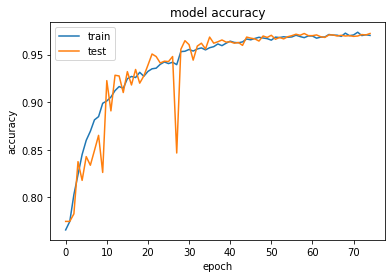

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()